In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(2003)

A myocardial infarction, better known as a heart attack, occurs when blood flow to the heart is blocked. This is often due to buildup of fat, cholesterol and other substances which form a plaque in the coronary arteries that feed blood to the heart. These cholesterol and other substance deposits can form a clot which restricts blood flow, resulting in the damage or disruption of the heart muscle. A myocardial infarction can be fatal (Heart attack - Symptoms and causes, 2020). Common symptoms include: Pressure, tightness, pain, a squeezing or arching sensation in chest or arms; shortness of breath; cold sweat; heartburn; fatigue; lightheadedness or sudden dizziness. Among the estimated 17.9 million people who die from Cardiovascular Disease each year, according to the World Health Organization (WHO) statistics, heart attack and stroke account for 85% of those deaths. 

In [15]:
url <- "https://raw.githubusercontent.com/riddhibattu/DSCI_heart_project/main/heart.csv"
heart <- read_csv(url) %>%
mutate(cp = as_factor(cp)) %>%
select(age, sex, chol, cp)
heart

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trtbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalachh = col_double(),
  exng = col_double(),
  oldpeak = col_double(),
  slp = col_double(),
  caa = col_double(),
  thall = col_double(),
  output = col_double()
)



age,sex,chol,cp
<dbl>,<dbl>,<dbl>,<fct>
63,1,233,3
37,1,250,2
41,0,204,1
⋮,⋮,⋮,⋮
68,1,193,0
57,1,131,0
57,0,236,1


In [20]:
heart_plot <- heart %>%
options(repr.plot.width= 12, repr.plot.height=12)
heart_plot <- heart %>%
  ggplot(aes(x = age, y = chol)) +
  geom_point(aes(color = cp), alpha = 0.5) +
  labs(x = "Age", y = "Cholesterol Level of Patients", color = "Chest Pain Type") +
  scale_color_manual(labels = c("Asymptomatic No Pain", "Typical Angina", "Atypical Angina", "Non-Anginal Pain"),
                      values = c("orange2", "steelblue2", "red", "blue")) + 
  theme(text = element_text(size = 15)) +
  ggtitle("Age and Cholesterol Level of Patients") +
  theme(text = element_text(size = 18))

#geom_point(aes(color = cp)) +
#labs(x = "Age",
    #y = "Cholesterol Level of Patients",
    #color = "Chest Pain Type") +
    #scale_color_manual(labels = c("Asymptomatic No Pain", "Typical Angina", "Atypical Angina", "Non-Anginal Pain"),
                      #values = c("orange2", "steelblue2", "red", "blue"))+ 
  #theme(text = element_text(size = 15))
                               
    
heart_plot


ERROR: Error in options(., repr.plot.width = 12, repr.plot.height = 12): invalid argument


In [17]:
heart_split <- initial_split(heart, prop = 3/4, strata = cp)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

#knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
#set_engine("kknn") %>%
#set_mode("classification")

#heart_recipe <- recipe(cp ~ chol + age, data = heart_training) %>%
#step_scale(all_predictors()) %>%
#step_center(all_predictors())

#heart_fit <- workflow() %>%
#add_model(knn_spec) %>%
#add_recipe(heart_recipe) %>%
#fit(heart_training)

#heart_predict <- predict(heart_fit, heart_testing) %>%
#bind_cols(heart_testing) %>%
#filter(.pred_class == cp)

#heart_predict

! Fold09: internal: No observations were detected in `truth` for level(s): '3'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3840797,10,0.04483102,Model01
3,accuracy,multiclass,0.3965652,10,0.04668843,Model02
5,accuracy,multiclass,0.3492022,10,0.04342025,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
71,accuracy,multiclass,0.4908215,10,0.02866905,Model36
73,accuracy,multiclass,0.4771851,10,0.02566428,Model37
75,accuracy,multiclass,0.4771851,10,0.02566428,Model38


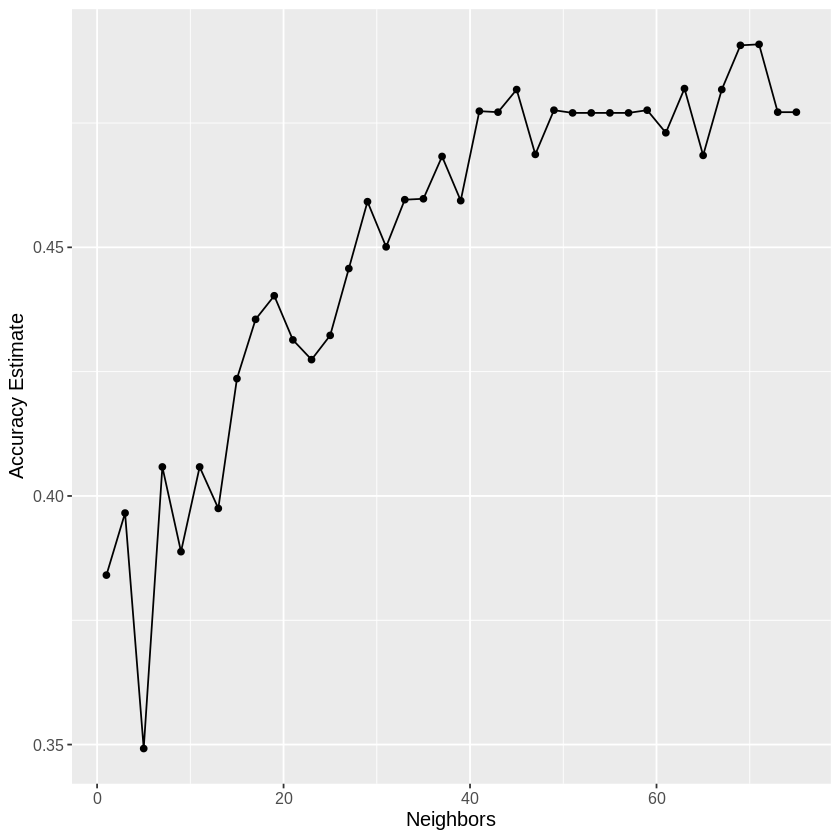

In [18]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

heart_recipe <- recipe(cp ~ chol + age, data = heart_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

heart_train_vfold <- vfold_cv(heart_training, v = 10, strata = cp)

k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 2))

heart_cv_result <- workflow() %>%
add_model(knn_spec) %>%
add_recipe(heart_recipe) %>%
tune_grid(resamples = heart_train_vfold, grid = k_vals) %>%
collect_metrics()

accuracy <- heart_cv_result %>%
filter(.metric == "accuracy")

accuracy

k_values_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
theme(text = element_text(size = 12))
k_values_plot

In [19]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
set_engine("kknn") %>%
set_mode("classification")

heart_fit_2 <- workflow() %>%
add_model(knn_spec_2) %>%
add_recipe(heart_recipe) %>%
fit(heart_training)

heart_predict <- predict(heart_fit_2, heart_testing) %>%
bind_cols(heart_testing)

heart_metrics <- metrics(heart_predict, truth = cp, estimate = .pred_class)

heart_conf_mat <- heart_predict %>%
conf_mat(truth = cp, estimate = .pred_class)

heart_metrics

heart_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.48648649
kap,multiclass,0.07621551


          Truth
Prediction  0  1  2  3
         0 29  7 16  4
         1  2  1  0  0
         2  6  2  6  1
         3  0  0  0  0